In [1]:
pip -q install numpy pandas scikit-learn opencv-python tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, cv2, random, joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# ===== 1. 경로 설정 및 데이터 로딩 함수 정의 =====
TRAIN_IMG_PATH = r"C:/Users/82106/downloads/cifar-10/train/train"
TRAIN_LABELS   = r"C:/Users/82106/downloads/cifar-10/trainLabels.csv"
RANDOM_SEED    = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

def read_flatten(path):
    """이미지 경로를 받아 전처리 후 1차원 벡터로 반환하는 함수"""
    img = cv2.imread(path)
    if img is None:
        return None
    # 픽셀 값을 0~1 사이로 정규화하고 1차원으로 펼칩니다.
    return (img.astype(np.float32) / 255.0).flatten()

# ===== 2. 전체 훈련(Train) 데이터 로드 (50,000장) =====
labels_df = pd.read_csv(TRAIN_LABELS)
labels_df['id'] = pd.to_numeric(labels_df['id'], errors='coerce').astype('int')

X, y = [], []
print(f"[INFO] 전체 훈련 데이터 {len(labels_df):,}장을 로딩합니다...")
for img_id, label in tqdm(labels_df[['id', 'label']].itertuples(index=False), total=len(labels_df)):
    v = read_flatten(os.path.join(TRAIN_IMG_PATH, f"{img_id}.png"))
    if v is None:
        continue
    X.append(v)
    y.append(label)

X = np.array(X, dtype=np.float32)
y = np.array(y)
print(f"[INFO] 데이터 로딩 완료. X: {X.shape}, y: {y.shape}")


# ===== 3. 교차 검증을 위한 파이프라인 및 파라미터 그리드 설정 =====
# PCA=256, metric='cosine'을 고정값으로 사용
# k값의 변화에 따른 성능 측정에 집중
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=256, whiten=True, random_state=RANDOM_SEED)),
    ("knn", KNeighborsClassifier(metric='cosine', n_jobs=-1))
])

# 탐색할 k값의 범위를 지정
k_vals = [1, 3, 5, 7, 9, 11, 13, 15]
param_grid = {
    'knn__n_neighbors': k_vals
}

# ===== 4. GridSearchCV를 이용한 5-Fold 교차 검증 수행 =====
# GridSearchCV가 전체 데이터(X, y)를 알아서 5-fold로 나누어 학습/검증을 반복
print("\n[INFO] GridSearchCV를 사용하여 5-fold 교차 검증을 시작합니다...")
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                     # 5-fold 교차 검증
    scoring='accuracy',       # 평가지표는 우선 '정확도'로 설정
    verbose=3,                
    n_jobs=1                  
)
grid_search.fit(X, y)

# ===== 5. 교차 검증 결과 요약 =====
print("\n[INFO] 교차 검증 완료!")
print(f"최적의 K값: {grid_search.best_params_['knn__n_neighbors']}")
print(f"해당 K값에서의 평균 교차 검증 정확도: {grid_search.best_score_:.4f}")

# 최적의 모델(파이프라인)을 저장
best_model = grid_search.best_estimator_
joblib.dump(best_model, "best_knn_model_cv.pkl")
print("\n[INFO] 최적 모델을 'best_knn_model_cv.pkl' 파일로 저장했습니다.")

# 다음 셀에서 시각화 및 상세 리포트를 위해 grid_search 객체를 계속 사용


[INFO] 전체 훈련 데이터 50,000장을 로딩합니다...


100%|██████████| 50000/50000 [10:43<00:00, 77.70it/s] 


[INFO] 데이터 로딩 완료. X: (50000, 3072), y: (50000,)

[INFO] GridSearchCV를 사용하여 5-fold 교차 검증을 시작합니다...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ................knn__n_neighbors=1;, score=0.444 total time=  20.7s
[CV 2/5] END ................knn__n_neighbors=1;, score=0.426 total time=  19.3s
[CV 3/5] END ................knn__n_neighbors=1;, score=0.436 total time=  17.8s
[CV 4/5] END ................knn__n_neighbors=1;, score=0.437 total time=  17.7s
[CV 5/5] END ................knn__n_neighbors=1;, score=0.430 total time=  18.7s
[CV 1/5] END ................knn__n_neighbors=3;, score=0.432 total time=  18.5s
[CV 2/5] END ................knn__n_neighbors=3;, score=0.411 total time=  18.5s
[CV 3/5] END ................knn__n_neighbors=3;, score=0.424 total time=  19.7s
[CV 4/5] END ................knn__n_neighbors=3;, score=0.424 total time=  18.7s
[CV 5/5] END ................knn__n_neighbors=3;, score=0.418 total time=  20.0s
[CV 1/5] END ................knn

[INFO] K값에 따른 교차 검증 정확도 시각화를 시작합니다...


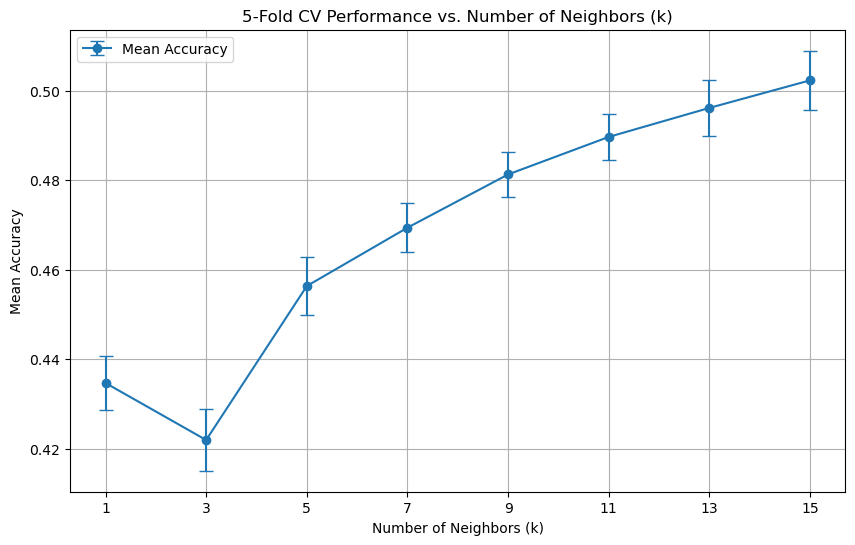


[INFO] 최적 모델의 상세 평가지표(Precision, Recall, F1-score)를 계산합니다...
              precision    recall  f1-score   support

    airplane       0.45      0.68      0.54      5000
  automobile       0.58      0.64      0.61      5000
        bird       0.38      0.50      0.43      5000
         cat       0.35      0.33      0.34      5000
        deer       0.46      0.41      0.44      5000
         dog       0.45      0.38      0.41      5000
        frog       0.62      0.46      0.53      5000
       horse       0.64      0.56      0.59      5000
        ship       0.56      0.70      0.62      5000
       truck       0.70      0.36      0.47      5000

    accuracy                           0.50     50000
   macro avg       0.52      0.50      0.50     50000
weighted avg       0.52      0.50      0.50     50000


[INFO] 저장된 최적 모델을 불러와 전체 테스트 데이터 예측을 시작합니다...
[주의] 30만장 전체를 예측하므로 매우 오랜 시간이 소요될 수 있습니다.
[INFO] 전체 테스트 이미지 300,000장을 로딩합니다...


100%|██████████| 300000/300000 [1:03:26<00:00, 78.81it/s] 


[INFO] 최종 모델로 전체 30만장 예측을 수행합니다...

[INFO] 'submission_cv_300k.csv' 파일 저장이 완료되었습니다.
   id     label
0   1      ship
1   2  airplane
2   3     truck
3   4  airplane
4   5  airplane


In [3]:
import os, cv2, random, joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

# ===== 6. K값에 따른 교차 검증 성능 시각화 =====
print("[INFO] K값에 따른 교차 검증 정확도 시각화를 시작합니다...")
k_vals_from_grid = grid_search.cv_results_['param_knn__n_neighbors'].data
mean_scores = grid_search.cv_results_['mean_test_score']
std_scores = grid_search.cv_results_['std_test_score']
plt.figure(figsize=(10, 6))
plt.errorbar(k_vals_from_grid, mean_scores, yerr=std_scores, fmt='-o', capsize=5, label='Mean Accuracy')
plt.title('5-Fold CV Performance vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Accuracy')
plt.xticks(k_vals_from_grid)
plt.legend()
plt.grid(True)
plt.show()

# ===== 7. 상세 평가지표 보고 =====
print("\n[INFO] 최적 모델의 상세 평가지표(Precision, Recall, F1-score)를 계산합니다...")
y_pred_cv = cross_val_predict(estimator=best_model, X=X, y=y, cv=5, n_jobs=1)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
report = classification_report(y, y_pred_cv, target_names=class_names)
print(report)


# ===== 8. 최종 Test 데이터 예측 및 제출 파일 생성 (전체 30만장) =====
print("\n[INFO] 저장된 최적 모델을 불러와 전체 테스트 데이터 예측을 시작합니다...")
print("[주의] 30만장 전체를 예측하므로 매우 오랜 시간이 소요될 수 있습니다.")
TEST_IMG_PATH = r"C:/Users/82106/Downloads/cifar-10/test/test"

# 테스트 이미지 파일 목록 전체를 불러옵니다.
test_files = [f for f in os.listdir(TEST_IMG_PATH) if f.lower().endswith(".png")]
test_files = sorted(test_files, key=lambda x: int(os.path.splitext(x)[0]))

# 전체 test_files 리스트를 사용
X_test, test_ids = [], []
print(f"[INFO] 전체 테스트 이미지 {len(test_files):,}장을 로딩합니다...")
# [주의] 이 과정에서 약 3.7GB의 메모리가 필요. MemoryError가 발생할 수 있음 
for f in tqdm(test_files):
    iid = int(os.path.splitext(f)[0])
    v = read_flatten(os.path.join(TEST_IMG_PATH, f))
    if v is None: continue
    X_test.append(v)
    test_ids.append(iid)

X_test = np.array(X_test, dtype=np.float32)

loaded_model = joblib.load("best_knn_model_cv.pkl")

print("[INFO] 최종 모델로 전체 30만장 예측을 수행합니다...")
test_pred_labels = loaded_model.predict(X_test)

submission = pd.DataFrame({"id": test_ids, "label": test_pred_labels}).sort_values("id")
submission.to_csv("submission_cv_300k.csv", index=False)
print("\n[INFO] 'submission_cv_300k.csv' 파일 저장이 완료되었습니다.")
print(submission.head())
